It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb)

# Introduction

Recurrent neural networks (RNN) are a class of neural networks that are powerful for
modeling sequence data such as time series or natural language.

The Keras RNN API is designed with a focus on:

- **Ease of use**: the built-in `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` layers enable you to quickly build recurrent models without
having to make difficult configuration choices.

- **Ease of customization**: You can also define your own RNN cell layer (the inner
part of the `for` loop) with custom behavior, and use it with the generic
`keras.layers.RNN` layer (the `for` loop itself). This allows you to quickly
prototype different research ideas in a flexible way with minimal code.



Points to note, Keras calls input weight as kernel, the hidden matrix as recurrent_kernel and bias as bias. Now let's go through the parameters exposed by Keras. While the complete list is provided, we will look at some of the relevant ones briefly.

- **units**:  Equal to the size of the output of both kernel and recurrent_kernel. dimensionality of the output space.


- **activation**: which defined the g() function in our formulation. Default is `tanh`.

- **{*}_initializer** , **{*}_regularizer** and **{*}_constraint parameters**: each for kernel, recurrent_kernel and bias. These could be ignored.

- **use_bias**: Boolean, (default True), whether the layer uses a bias vector.

- **dropout** and **recurrent_dropout**: Apply dropout to kernel (linear transformation of the inputs) and recurrent_kernel (recurrent state) respectively.

- **return_sequences**: Boolean (Default: False). Whether to return the last output in the output sequence, or the full sequence. Default: False. When it's "True", the output shape of the RNN layer is (timestamp, feature) and when its "False" the output is only (features). This means, if its turn on, in output we return the y{t} from all time-steps, and if it's off then we only return 1 y{t} (here from the last time-step). An additional caveat, don't forget to add a TimeDistributed layer or Flatten layer after an RNN with return_sequence turned on before you add a Dense layer.

- **go_backwards**: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence

- **return_state** is of boolean type and when "True" it returns the last state in addition to the output. Default is "False".

- **stateful**: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch. Usually, after running on each sample in a batch, the state of the RNN cell is reset. But if we have prepared the data in a format such that across multiple batches, samples at a particular index are just an extension of the same sentence, we can turn stateful as "True" and it will be equivalent to training all sentences at once (as one sample).



In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Simple Architectures

There are three built-in RNN layers in Keras:

1. [`keras.layers.SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/), a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

```python
tf.keras.layers.SimpleRNN(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````

2. [`keras.layers.GRU`](https://keras.io/api/layers/recurrent_layers/gru/), first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).
```python
tf.keras.layers.GRU(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
```

3. [`keras.layers.LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/), first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).
```python
tf.keras.layers.LSTM(
    units,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
)
````


Call arguments:

- **inputs**: A 3D tensor with shape [batch, timesteps, feature].
- **mask**: Binary tensor of shape [batch, timesteps] indicating whether a given timestep should be masked (optional, defaults to None).
- **training**: Python boolean indicating whether the layer should behave in training mode or in inference mode. This argument is passed to the cell when calling it. This is only relevant if dropout or recurrent_dropout is used (optional, defaults to None).
- **initial_state**: List of initial state tensors to be passed to the first call of the cell (optional, defaults to None which causes creation of zero-filled initial state tensors).

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

Lets see some examples for understanding the input/output dimensions

In [5]:
# dims of input: [batch, timesteps, features]
inputs = tf.random.normal([32, 10, 8])
print('input dim (batch, timesteps, feature): ', inputs.shape)
# return_sequences=False, return_state=False
lstm = tf.keras.layers.LSTM(units= 4)
output = lstm(inputs)
print('return_state=False output shape: ',output.shape)

lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print('whole_seq_output shape: ', whole_seq_output.shape)
print('final_memory_state shape: ',final_memory_state.shape)
print('final_carry_state shape: ',final_carry_state.shape)


input dim (batch, timesteps, feature):  (32, 10, 8)
return_state=False output shape:  (32, 4)
whole_seq_output shape:  (32, 10, 4)
final_memory_state shape:  (32, 4)
final_carry_state shape:  (32, 4)


Simple examples of a `Sequential` model.  `timesteps = 10, features = 8`

Many-to many model:

In [6]:
timesteps = 10
features = 8 # dimension of the innput of every cell
#Shape [batch, timesteps, features] => [batch, timesteps, 5]
model = keras.Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(timesteps, features)))
# Add a Dense layer with 5 units.
#model.add(tf.keras.layers.TimeDistributed(layers.Dense(5)))
model.add(layers.Dense(5))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 128)           70144     
_________________________________________________________________
dense (Dense)                (None, 10, 5)             645       
Total params: 70,789
Trainable params: 70,789
Non-trainable params: 0
_________________________________________________________________


In [4]:
# see ouputs
inputs = tf.random.normal([32, timesteps, features])
print(inputs.shape)
print(model(inputs).shape)

(32, 10, 8)
(32, 10, 5)


We can see that if our `input_shape=(timesteps, features)` the ouput of the model will be `input_shape=(batch_size,timesteps, last_layer_ouput_dim)` because we have `return_sequences=True`

if we set `return_sequences=False`, we only have the last cell output, we will have many-to-one model:

In [5]:
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features] 
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_layer = layers.LSTM(128, return_sequences=False, name='lstm_1')(inputs)
model = keras.Model(inputs=inputs, outputs=lstm_layer, name='rnn_example')

model.summary()

Model: "rnn_example"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10, 8)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
Total params: 70,144
Trainable params: 70,144
Non-trainable params: 0
_________________________________________________________________


In [6]:
# see ouputs
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 128)


In [7]:
## Adding a last softmax  
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features] 
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_layer = layers.LSTM(128, return_sequences=False, name='lstm_1')(inputs)
outputs = layers.Dense(5, activation='softmax', name='output')(lstm_layer)
model = keras.Model(inputs=inputs, outputs=outputs, name='rnn_example')

inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 5)


In [8]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features] 
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
dense_1 = tf.keras.layers.TimeDistributed(layers.Dense(5))(inputs)
lstm_layer = layers.LSTM(128, return_sequences=False, name='lstm_1')(dense_1)
outputs = layers.Dense(5, activation='softmax', name='output')(lstm_layer)
model = keras.Model(inputs=inputs, outputs=outputs, name='rnn_example')

inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 5)


### Seq to seq model

Keras provides the `return_state` argument to the LSTM layer that will provide access to the hidden state output (state_h) and the cell state (state_c). Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [9]:
# Encoder
encoder_input = tf.keras.Input(
    shape=(timesteps, features), name='encoder_input')

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_input
)

# Enncoded vector
encoder_state = [state_h, state_c]

# Decoder
decoder_input = tf.keras.Input(
    shape=(timesteps, features), name='decoder_input')

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, return_sequences=True, name="decoder")(
    decoder_input, initial_state=encoder_state
)
output = layers.Dense(5)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  18688       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (LSTM)                  (None, 10, 64)       18688       decoder_input[0][0]              
                                                                 encoder[0][1]                

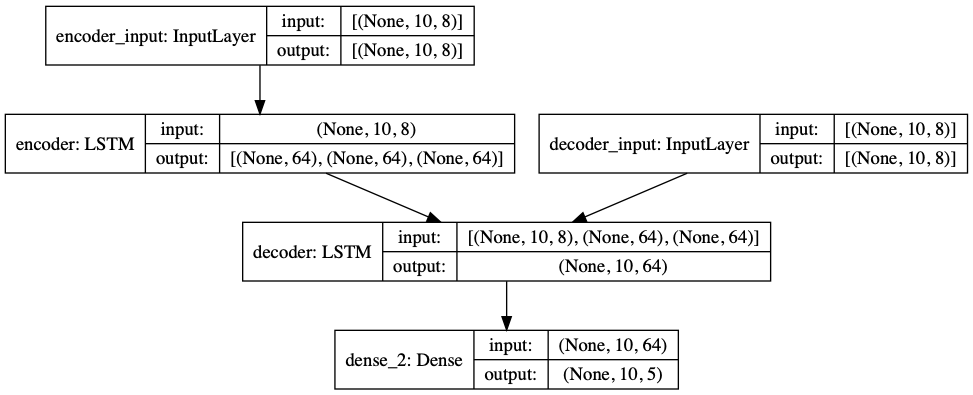

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [11]:
inputs1 = tf.random.normal([32, timesteps, features])
inputs2 = tf.random.normal([32, timesteps, features])
print(model([inputs1, inputs2]).shape)

(32, 10, 5)


### Deep RNN
We can stack multiple layers of RNNs on top of each other. Each hidden state is continuously passed to both the next time step of the current layer and the current time step of the next layer.

For stack another RNN layer to an existing one, we need to use the states with `return_sequences=True`

In [12]:
## We can modify the input vector before the rnn cell with TimeDistributed
timesteps = 10
features = 8 # dimension of the innput of every cell

#Shape [batch, timesteps, features] 
inputs = tf.keras.Input(shape=(timesteps, features), name='input')
lstm_1 = layers.LSTM(64, return_sequences=True, name='lstm_1')(inputs)
lstm_2 = layers.LSTM(64, return_sequences=True, name='lstm_2')(lstm_1)
# last lstm layer depends in [one to many or  many to many]
lstm_3 = layers.LSTM(64, return_sequences=False, name='lstm_3')(lstm_2)
model = keras.Model(inputs=inputs, outputs=lstm_3, name='rnn_example')
#print(model.summary())
inputs = tf.random.normal([32, timesteps, features])
print(model(inputs).shape)

(32, 64)


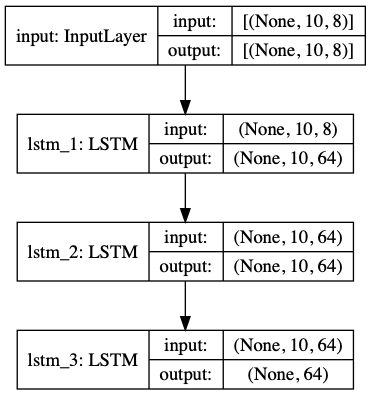

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

In [14]:
model = keras.Sequential()

# If you crete a second layer you must set return_sequences=True
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(timesteps, features))
)
# Second Bidirectional layer
model.add(layers.Bidirectional(layers.LSTM(32)))
# Output
model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 128)           37376     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 79,242
Trainable params: 79,242
Non-trainable params: 0
_________________________________________________________________


### ConvLSTM

It is a Recurrent layer but internal matrix multiplications are exchanged with convolution operations. The data keeps the dimensions (3 dimension).
 
The input of a ConvLSTM is a set of images over time as a 5D tensor with shape `(batch_size, timesteps, rows, cols, channels)`
 
The ConvLSTM layer output is a combination of a Convolution and a LSTM output. Just like the LSTM, if return_sequences = True, then it returns a sequence as a 5D tensor with shape `(batch_size, timesteps, rows, cols, filters)`. If `return_sequences = False`, then it returns  4D tensor with shape `(batch_size, rows, cols, filters)`.
 
[link to documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D)

In [15]:
# Adding a last softmax
timesteps = 10
img_size = (128, 128, 3)  # (rows, cools, channels)

# Shape [batch, timesteps, features]
inputs = tf.keras.Input(shape=(timesteps,) + img_size, name='input')
convlstm_layer = tf.keras.layers.ConvLSTM2D(
    8, kernel_size=3, padding='same', return_sequences=False, name='convlstm_1',
    data_format='channels_last')(inputs)
outputs = convlstm_layer
model = keras.Model(inputs=inputs, outputs=outputs, name='rnn_example')

inputs = tf.random.normal((32,)+(timesteps,) + img_size)
print(model(inputs).shape)

(32, 128, 128, 8)


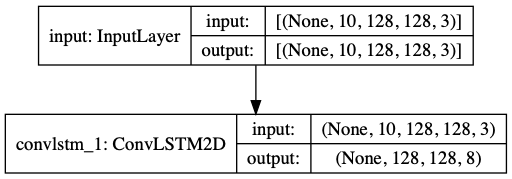

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Cross-batch statefulness

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

Normally, the internal state of a RNN layer is reset every time it sees a new batch
(i.e. every sample seen by the layer is assumed to be independent of the past). The
layer will only maintain a state while processing a given sample.

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer without
resetting the layer's state. That way, the layer can retain information about the
entirety of the sequence, even though it's only seeing one sub-sequence at a time.

You can do this by setting `stateful=True` in the constructor.

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into e.g.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.


> Note: In this setup, sample `i` in a given batch is assumed to be the continuation of
sample `i` in the previous batch. This means that all batches should contain the same
number of samples (batch size). E.g. if a batch contains `[sequence_A_from_t0_to_t100,
 sequence_B_from_t0_to_t100]`, the next batch should contain
`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.




Here is a complete example:

In [17]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


## Time Series Analysis

#### Windowing sequences

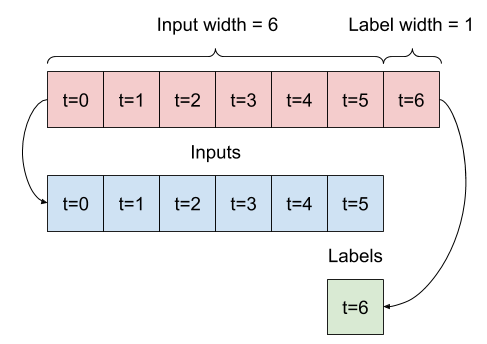

Creates a dataset of sliding windows over a timeseries provided as array with [timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array).



For creating the windows we use [timeseries_dataset_from_array](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

```python
tf.keras.preprocessing.timeseries_dataset_from_array(
    data, targets, sequence_length, sequence_stride=1, sampling_rate=1,
    batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None
)
```

Example : Consider an array data of scalar values, of shape (steps,). To generate a dataset that uses the past 10 timesteps to predict the second next timestep, you would use:
`sequence_length=10`

In [18]:
past = 10
future = 1 # number of next timesteps to predict

data = np.arange(21)
input_data = data[:-10]
targets = data[10:]
print('data', data)
print('input_data: ', input_data)
print('targets: ', targets)

dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    input_data, targets, sequence_length=past, batch_size=3)
for inputs, targets in dataset:
    for i in range(len(inputs)):
        print('window,target: ',inputs[i,:].numpy(), targets[i].numpy())
        assert np.array_equal(inputs[i,:], data[i:10+i])  # First sequence: steps [0-9]
        # Corresponding target: step 10
        assert np.array_equal(targets[i], data[10+i])
    break
    

data [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
input_data:  [ 0  1  2  3  4  5  6  7  8  9 10]
targets:  [10 11 12 13 14 15 16 17 18 19 20]
window,target:  [0 1 2 3 4 5 6 7 8 9] 10
window,target:  [ 1  2  3  4  5  6  7  8  9 10] 11


For example if  `dataset = [0,1,2,3,4,5,6,7,8,9,10]` and `train_split=7`:

```python
train = dataset[0:7] = [0,1,2,3,4,5,6]
test = dataset[7:] = [7,8,9,10]
```
If we have `past=3`, and `future=2`, we use **windows of size 3** for predicting **2 steps ahead**.

we are going to use `dataset[:past]=[0,1,2]` to predict `dataset[past+future-1]=dataset[4]=4`, 

We need too create a training data like
```python
# target index to start = past+future-1 = 4
[0,1,2], 4 # dataset[:past], dataset[:start](dataset[5])
[1,2,3], 5 # dataset[1:past+1], dataset[1:start+1]
[2,3,4], 6 # dataset[2:past+2], dataset[2:start+2]
# target index to end = train_split - 1 = 6
# train index to end = train_split - future -1 = 4,dataset[4] = 4
```

In [19]:
dataset = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
train_split = 7
train = dataset[0:train_split]  # = [0,1,2,3,4,5,6]
test = dataset[train_split:]  # = [7,8,9,10, 11, 12, 13, 14]
# lenght of sequence for predicting
past = 3
# future steps to predict
future = 2
sequence_length = int(past)  # the that steps we use to predict

# start and end training set
# we use the first past steps to predict past + future - 1
start = past + future - 1

x_train = train[:-past+1]

for the function `timeseries_dataset_from_array` , `data`(x) and `targets` (y) must have the same dimension, we need to add padding to y 

In [20]:
y_train = train[start:]
## padding 
y_train = np.concatenate([y_train,
            np.zeros(len(x_train)-len(y_train))])

print('x', x_train)
print('y with padding', y_train)
batch_size=3
dataset_ts = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train, y_train, sequence_length=past, batch_size=batch_size)
for  batch in dataset_ts:
    inputs, targets = batch
    for i in range(len(inputs)):
        print('window,target: ',inputs[i,:].numpy(), targets[i].numpy())


x [0 1 2 3 4]
y with padding [4. 5. 6. 0. 0.]
window,target:  [0 1 2] 4.0
window,target:  [1 2 3] 5.0
window,target:  [2 3 4] 6.0


Create a function:

In [21]:
def prepare_dataset(ts, past, future, sequence_length,
                    batch_size):
    start = past + future - 1
    x = ts[:-past+1]
    y = ts[start:start + len(x)]
    # padding
    y = np.concatenate([y, np.zeros(len(x) - len(y))])
    dataset = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        batch_size=batch_size,
    )
    return dataset

dataset_ts = prepare_dataset(train, past, future, sequence_length,
                    batch_size)
for  inputs, targets in dataset_ts:
    for i in range(len(inputs)):
        print('window,target: ',inputs[i,:].numpy(), targets[i].numpy())


window,target:  [0 1 2] 4.0
window,target:  [1 2 3] 5.0
window,target:  [2 3 4] 6.0


In [22]:
## for validation
dataset_val = prepare_dataset(test, past, future, sequence_length,
                    8)
for inputs, targets in dataset_val:
    for i in range(len(inputs)):
        print('window,target: ',inputs[i,:].numpy(), targets[i].numpy())



window,target:  [7 8 9] 11.0
window,target:  [ 8  9 10] 12.0
window,target:  [ 9 10 11] 13.0
window,target:  [10 11 12] 14.0


### Airlines Dataset

In [23]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


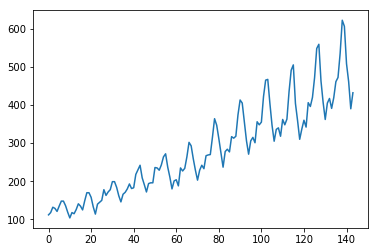

In [24]:
df = pd.read_csv('../data/airline-passengers.csv', usecols=[1])
dataset = df.values#.flatten()
plt.plot(dataset)
plt.show()

Split in train/test set and scale with  StandardScaler

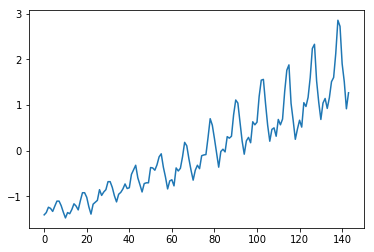

In [25]:
split_fraction = 0.75
train_split = int(split_fraction * int(len(dataset)))


from sklearn.preprocessing import StandardScaler
# scale the data
scaler = StandardScaler()
scaler.fit(dataset[:train_split])


dataset_s = scaler.fit_transform(dataset).flatten()
plt.plot(dataset_s)
plt.show()

In [26]:
# split into train and test sets
train, test = dataset_s[0:train_split], dataset_s[train_split:len(dataset)]
print(len(train), len(test))

108 36


In [27]:
# lenght of sequence for predicting
past = 2
# future steps to predict
future = 1
sequence_length = int(past)  # the that steps we use to predict
batch_size = 4
dataset_train = prepare_dataset(train, past, future, sequence_length,
                    batch_size)
dataset_val = prepare_dataset(test, past, future, sequence_length,
                    batch_size)


In [28]:
inputs_shape = (past, 1)
inputs = keras.layers.Input(shape=(past,1))
lstm_out_1 = keras.layers.LSTM(32, return_sequences=False)(inputs)
outputs = keras.layers.Dense(1)(lstm_out_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 2s 36ms/step - loss: 1.1724 - val_loss: 2.2084
Epoch 2/100
27/27 [==============================] - 0s 6ms/step - loss: 0.8159 - val_loss: 1.9507
Epoch 3/100
27/27 [==============================] - 0s 6ms/step - loss: 0.5471 - val_loss: 1.7061
Epoch 4/100
27/27 [==============================] - 0s 6ms/step - loss: 0.3237 - val_los

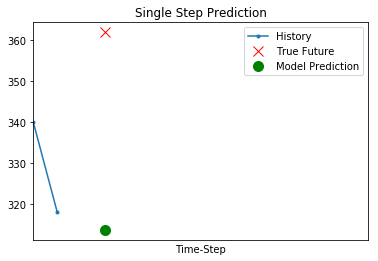

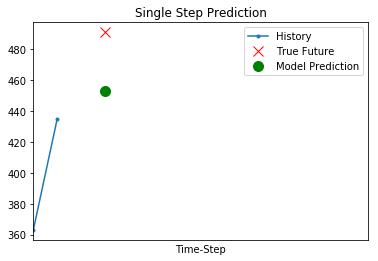

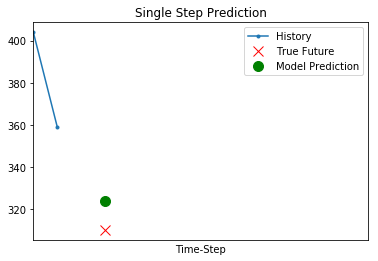

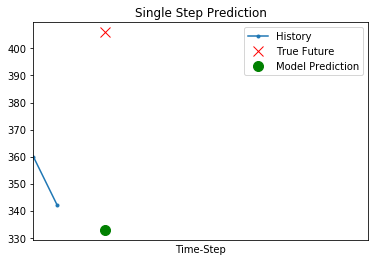

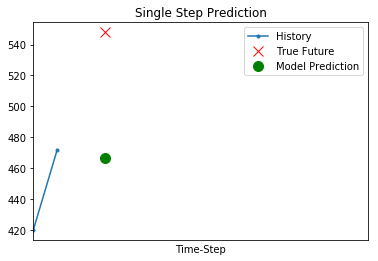

In [29]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xticks([])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    x_in = scaler.inverse_transform(x.numpy())
    y_in = scaler.inverse_transform(y.numpy())
    pred = scaler.inverse_transform(model.predict(x))
    show_plot(
        [x_in[0,:], y_in[0], pred.flatten()[0]],
        future,
        "Single Step Prediction",
    )

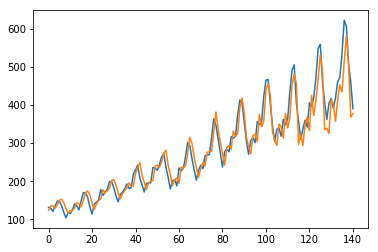

In [30]:
# future steps to predict
future = 1
sequence_length = int(past)  # the that steps we use to predict

x = dataset_s[:-past]
# first target oof first window is len(window) + future
y = dataset_s[past:]

batch_size=200
dataset_ts = tf.keras.preprocessing.timeseries_dataset_from_array(
    x, y, sequence_length=past, batch_size=batch_size)
for x, y in dataset_ts:
    x_in = scaler.inverse_transform(x.numpy())
    y_in = scaler.inverse_transform(y.numpy())
    pred = scaler.inverse_transform(model.predict(x))
    
plt.plot(y_in)
plt.plot(pred)
plt.show()

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [31]:
from zipfile import ZipFile
import os
import pandas as pd
import matplotlib.pyplot as plt


uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path, parse_dates =['Date Time'])
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

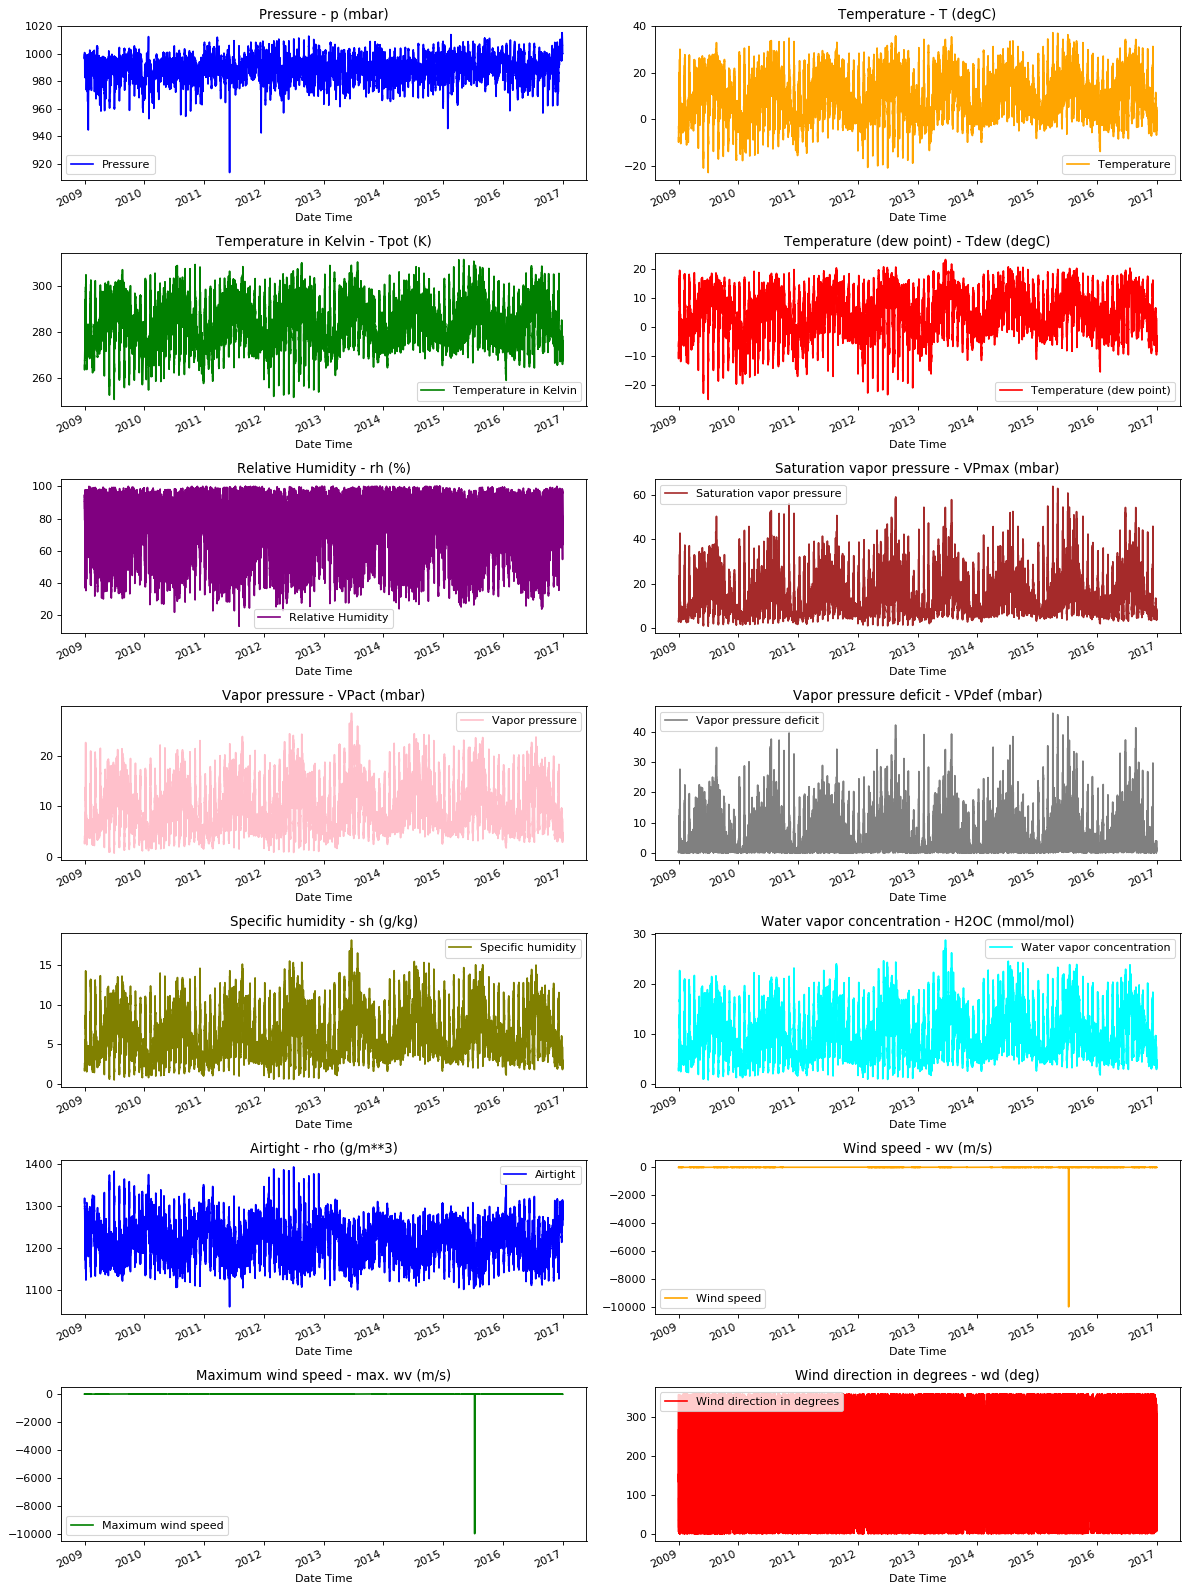

In [32]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

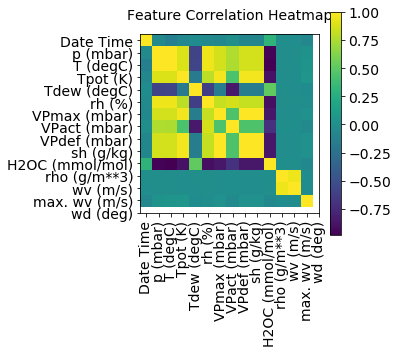

In [33]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [34]:
selected_features_title = ['Pressure', 'Temperature', 'Saturation vapor pressure',
                 'Vapor pressure deficit', 'Specific' 'humidity', 'Airtight', 'Wind speed']
selected_features = ['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)',
"max. wv (m/s)","wd (deg)" ]

### Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (76/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [35]:
df = df.set_index('Date Time')
## resample by the mean of hour values
df =df.resample('1h').mean().fillna(method='ffill') # 


In [36]:
#Use only important features
df = df[selected_features].copy()

In [37]:
df.values.shape

(35065, 9)

In [38]:
# train - test
split_fraction = 0.7
train_split = int(split_fraction * int(len(df)))

past = 6 # 1 * 24
future = 12
batch_size = 128


from sklearn.preprocessing import StandardScaler
# scale the data
scaler = StandardScaler()
scaler.fit(df.iloc[:train_split])

features = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

In [39]:
features.describe()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,35065.000000,35065.000000,35065.000000,35065.000000,35065.000000,35065.000000,35065.000000,35065.000000,35065.000000
mean,0.065621,0.040328,0.029756,0.014485,0.036566,-0.023697,-0.316540,-0.228847,0.024466
std,1.011353,0.972923,1.008002,1.018520,0.994704,0.975900,41.355743,28.302068,0.981937
min,-5.537838,-3.632409,-1.612944,-0.834087,-2.024465,-2.806760,-7125.637473,-4685.698793,-2.443881
25%,-0.540153,-0.662890,-0.726291,-0.645783,-0.751981,-0.721434,-0.766048,-0.786991,-0.389870
50%,0.110012,0.035724,-0.199578,-0.369288,-0.122308,-0.079312,-0.258998,-0.245150,0.251530
75%,0.730712,0.736944,0.558041,0.278905,0.704119,0.627968,0.465953,0.530527,0.674077
max,3.210482,3.208116,6.378929,8.447865,4.399578,4.264007,7.409686,7.650979,2.637420


We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [40]:
train_data = features.iloc[0 : train_split]
val_data = features.iloc[train_split:]

### Training and validation datasets



In [41]:
def prepare_dataset(df, past, future, sequence_length,
                    batch_size, target):
    start = past + future - 1
    x = df.iloc[:-past + 1]
    y = df.iloc[start:start + len(x)][target].values.flatten()
    # padding
    y = np.concatenate([y, np.zeros(len(x) - len(y))])
    dataset = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        batch_size=batch_size,
    )
    return dataset

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [42]:
sequence_length = int(past / 1)

dataset_train = prepare_dataset(train_data, past, future, sequence_length,
                    batch_size, target = 'T (degC)')
dataset_val = prepare_dataset(val_data, past, future, sequence_length,
                    batch_size, target= 'T (degC)')

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (128, 6, 9)
Target shape: (128,)


### Training

In [43]:
inputs = keras.layers.Input(shape=inputs_shape)
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6, 9)]            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [44]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)



Epoch 1/25
192/192 [==============================] - 5s 18ms/step - loss: 0.6563 - val_loss: 0.3931

Epoch 00001: val_loss improved from inf to 0.39312, saving model to model_checkpoint.h5
Epoch 2/25
192/192 [==============================] - 3s 16ms/step - loss: 0.4978 - val_loss: 0.3800

Epoch 00002: val_loss improved from 0.39312 to 0.37996, saving model to model_checkpoint.h5
Epoch 3/25
192/192 [==============================] - 3s 18ms/step - loss: 0.4808 - val_loss: 0.3745

Epoch 00003: val_loss improved from 0.37996 to 0.37450, saving model to model_checkpoint.h5
Epoch 4/25
192/192 [==============================] - 3s 16ms/step - loss: 0.4731 - val_loss: 0.3714

Epoch 00004: val_loss improved from 0.37450 to 0.37141, saving model to model_checkpoint.h5
Epoch 5/25
192/192 [==============================] - 3s 16ms/step - loss: 0.4682 - val_loss: 0.3696

Epoch 00005: val_loss improved from 0.37141 to 0.36959, saving model to model_checkpoint.h5
Epoch 6/25
192/192 [==============

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

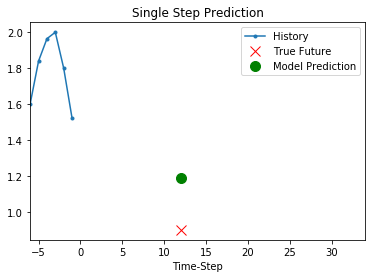

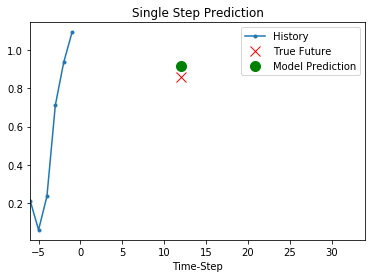

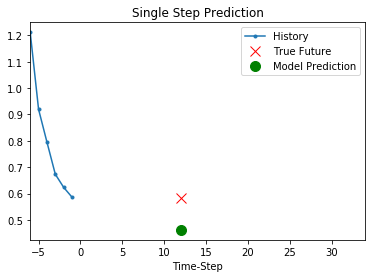

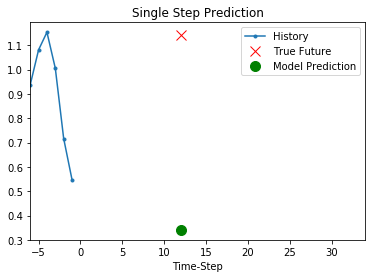

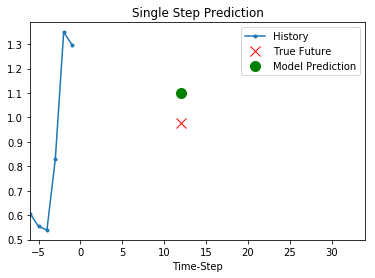

In [45]:
# 0.24822
# 0.26572
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )

batch:  0


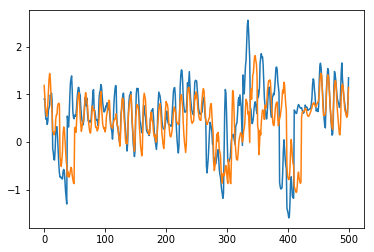

batch:  1


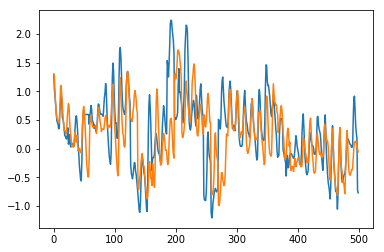

batch:  2


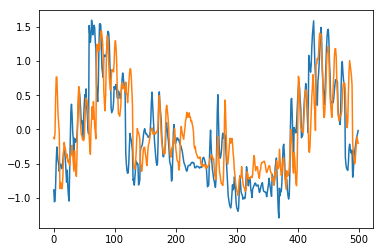

In [46]:
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future, sequence_length,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

### Feature Engineering
[reference](https://www.tensorflow.org/tutorials/structured_data/time_series)

Wind velocity
One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [47]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
df['wv (m/s)'] = wv

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0
df['max. wv (m/s)'] = max_wv


But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

In [48]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:


Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [49]:
from datetime import datetime
timestamp_s = df.index.map(datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [50]:
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),max. wv (m/s),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.526364,-8.173636,3.294545,0.201818,1.932727,1308.533636,0.843636,-0.406335,0.047407,-0.837953,0.097763,-0.258819,0.965926,0.008616,0.999963
2009-01-01 02:00:00,996.865833,-8.830000,3.128333,0.205833,1.824167,1312.315000,0.606667,-0.212199,0.011307,-0.605807,0.032279,0.258819,0.965926,0.010049,0.999950
2009-01-01 04:00:00,997.334167,-9.532500,2.958333,0.227500,1.707500,1316.527500,0.741667,-0.215491,0.219362,-0.519749,0.529085,0.707107,0.707107,0.011483,0.999934
2009-01-01 06:00:00,998.320000,-8.920833,3.108333,0.222500,1.796667,1314.706667,1.721667,-0.622159,-0.921261,-0.963553,-1.426780,0.965926,0.258819,0.012916,0.999917
2009-01-01 08:00:00,999.622500,-7.662500,3.427500,0.268333,1.970000,1310.043333,1.262500,-0.566548,-0.207448,-1.185524,-0.434095,0.965926,-0.258819,0.014349,0.999897


In [51]:
from sklearn.preprocessing import StandardScaler
# scale the data
scaler = StandardScaler()
scaler.fit(df.iloc[:train_split])

features = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

In [52]:
train_data = features.iloc[0 : train_split]
val_data = features.iloc[train_split:]

In [53]:
sequence_length = int(past / 1)

dataset_train = prepare_dataset(train_data, past, future, sequence_length,
                    batch_size, target = 'T (degC)')
dataset_val = prepare_dataset(val_data, past, future, sequence_length,
                    batch_size, target= 'T (degC)')

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
inputs_shape = (inputs.shape[1], inputs.shape[2])

Input shape: (500, 6, 15)
Target shape: (500,)


In [ ]:
inputs_shape = (inputs.shape[1], inputs.shape[2])
inputs = keras.layers.Input(shape=inputs_shape)
lstm_out_1 = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_out_2 = keras.layers.LSTM(32)(lstm_out_1)

outputs = keras.layers.Dense(1)(lstm_out_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

In [54]:
inputs_shape = (inputs.shape[1], inputs.shape[2])
inputs = keras.layers.Input(shape=inputs_shape)
lstm_out_1 = keras.layers.LSTM(32, return_sequences=True)(inputs)
lstm_out_2 = keras.layers.LSTM(32)(lstm_out_1)

outputs = keras.layers.Dense(1)(lstm_out_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6, 15)]           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 6, 32)             6144      
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 14,497
Trainable params: 14,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=25,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/25
50/50 [==============================] - 7s 89ms/step - loss: 0.7789 - val_loss: 0.3947

Epoch 00001: val_loss improved from inf to 0.39467, saving model to model_checkpoint.h5
Epoch 2/25
50/50 [==============================] - 4s 80ms/step - loss: 0.4762 - val_loss: 0.3764

Epoch 00002: val_loss improved from 0.39467 to 0.37641, saving model to model_checkpoint.h5
Epoch 3/25
35/50 [====================>.........] - ETA: 0s - loss: 0.4544

In [ ]:
# 0.21564
# 0.21186

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [ ]:
batch_size= 500
dataset_ts = prepare_dataset(val_data, past, future, sequence_length,
                    batch_size, target = 'T (degC)')
for i, (x, y) in enumerate(dataset_ts):
    if i >= 3:
        break
    print('batch: ', i)
    pred = model.predict(x)
    plt.plot(y.numpy())
    plt.plot(pred)
    plt.show()

## References

https://www.tensorflow.org/guide/keras/rnn

https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7

https://keras.io/examples/timeseries/timeseries_weather_forecasting/